In [14]:
! pip install verde
! pip install ensaio
! pip install cartopy

Original data:
  station_id  longitude  latitude  air_temperature_c  wind_speed_east_knots  \
0        0F2   -97.7756   33.6017           9.236111               1.032920   
1        11R   -96.3742   30.2189          14.214306               1.692155   
2        2F5  -101.9018   32.7479           7.069444              -1.110056   
3        3T5   -96.9500   29.9100          14.496761               1.695097   
4        5C1   -98.6946   29.7239          12.958333               1.271400   

   wind_speed_north_knots  
0               -2.357185  
1                2.982564  
2               -0.311412  
3                3.018448  
4                1.090743  

Trend estimator: Trend(degree=1)

Updated DataFrame:
  station_id  longitude  latitude  air_temperature_c  wind_speed_east_knots  \
0        0F2   -97.7756   33.6017           9.236111               1.032920   
1        11R   -96.3742   30.2189          14.214306               1.692155   
2        2F5  -101.9018   32.7479           7.06944

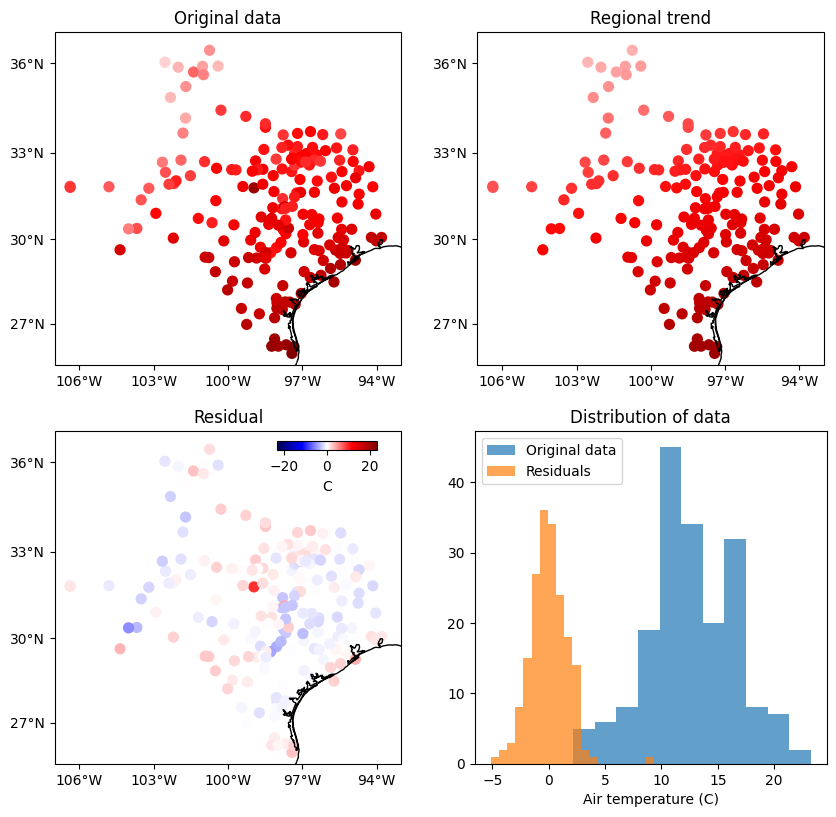

In [15]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import verde as vd

# Load the Texas wind and temperature data as a pandas.DataFrame
data = vd.datasets.fetch_texas_wind()
print("Original data:")
print(data.head())

# Fit a 1st degree 2D polynomial to the data
coordinates = (data.longitude, data.latitude)
trend = vd.Trend(degree=1).fit(coordinates, data.air_temperature_c)
print("\nTrend estimator:", trend)

# Add the estimated trend and the residual data to the DataFrame
data["trend"] = trend.predict(coordinates)
data["residual"] = data.air_temperature_c - data.trend
print("\nUpdated DataFrame:")
print(data.head())


# Make a function to plot the data using the same colorbar
def plot_data(column, i, title):
    "Plot the column from the DataFrame in the ith subplot"
    crs = ccrs.PlateCarree()
    ax = plt.subplot(2, 2, i, projection=ccrs.Mercator())
    ax.set_title(title)
    # Set vmin and vmax to the extremes of the original data
    maxabs = vd.maxabs(data.air_temperature_c)
    mappable = ax.scatter(
        data.longitude,
        data.latitude,
        c=data[column],
        s=50,
        cmap="seismic",
        vmin=-maxabs,
        vmax=maxabs,
        transform=crs,
    )
    # Set the proper ticks for a Cartopy map
    vd.datasets.setup_texas_wind_map(ax)
    return mappable


plt.figure(figsize=(10, 9.5))

# Plot the data fields and capture the mappable returned by scatter to use for
# the colorbar
mappable = plot_data("air_temperature_c", 1, "Original data")
plot_data("trend", 2, "Regional trend")
plot_data("residual", 3, "Residual")

# Make histograms of the data and the residuals to show that the trend was
# removed
ax = plt.subplot(2, 2, 4)
ax.set_title("Distribution of data")
ax.hist(data.air_temperature_c, bins="auto", alpha=0.7, label="Original data")
ax.hist(data.residual, bins="auto", alpha=0.7, label="Residuals")
ax.legend()
ax.set_xlabel("Air temperature (C)")

# Add a single colorbar on top of the histogram plot where there is some space
cax = plt.axes((0.35, 0.44, 0.10, 0.01))
cb = plt.colorbar(
    mappable,
    cax=cax,
    orientation="horizontal",
)
cb.set_label("C")

plt.show()

In [16]:
import ensaio
import pandas as pd
import xarray as xr


data = pd.read_csv(ensaio.fetch_southern_africa_gravity(version=1))
topography = xr.load_dataarray(ensaio.fetch_southern_africa_topography(version=1))
geoid  = xr.load_dataarray(ensaio.fetch_earth_geoid(version=1))

In [17]:
print(data)
print(topography)
print(geoid)

       longitude  latitude  height_sea_level_m  gravity_mgal
0       18.34444 -34.12971                32.2     979656.12
1       18.36028 -34.08833               592.5     979508.21
2       18.37418 -34.19583                18.4     979666.46
3       18.40388 -34.23972                25.0     979671.03
4       18.41112 -34.16444               228.7     979616.11
...          ...       ...                 ...           ...
14354   21.22500 -17.95833              1053.1     978182.09
14355   21.27500 -17.98333              1033.3     978183.09
14356   21.70833 -17.99166              1041.8     978182.69
14357   21.85000 -17.95833              1033.3     978193.18
14358   21.98333 -17.94166              1022.6     978211.38

[14359 rows x 4 columns]
<xarray.DataArray 'topography' (latitude: 1182, longitude: 1371)> Size: 13MB
array([[-5039., -5027., -5014., ..., -3846., -3867., -3873.],
       [-5036., -5021., -5007., ..., -3839., -3863., -3872.],
       [-5031., -5016., -5001., ..., -383

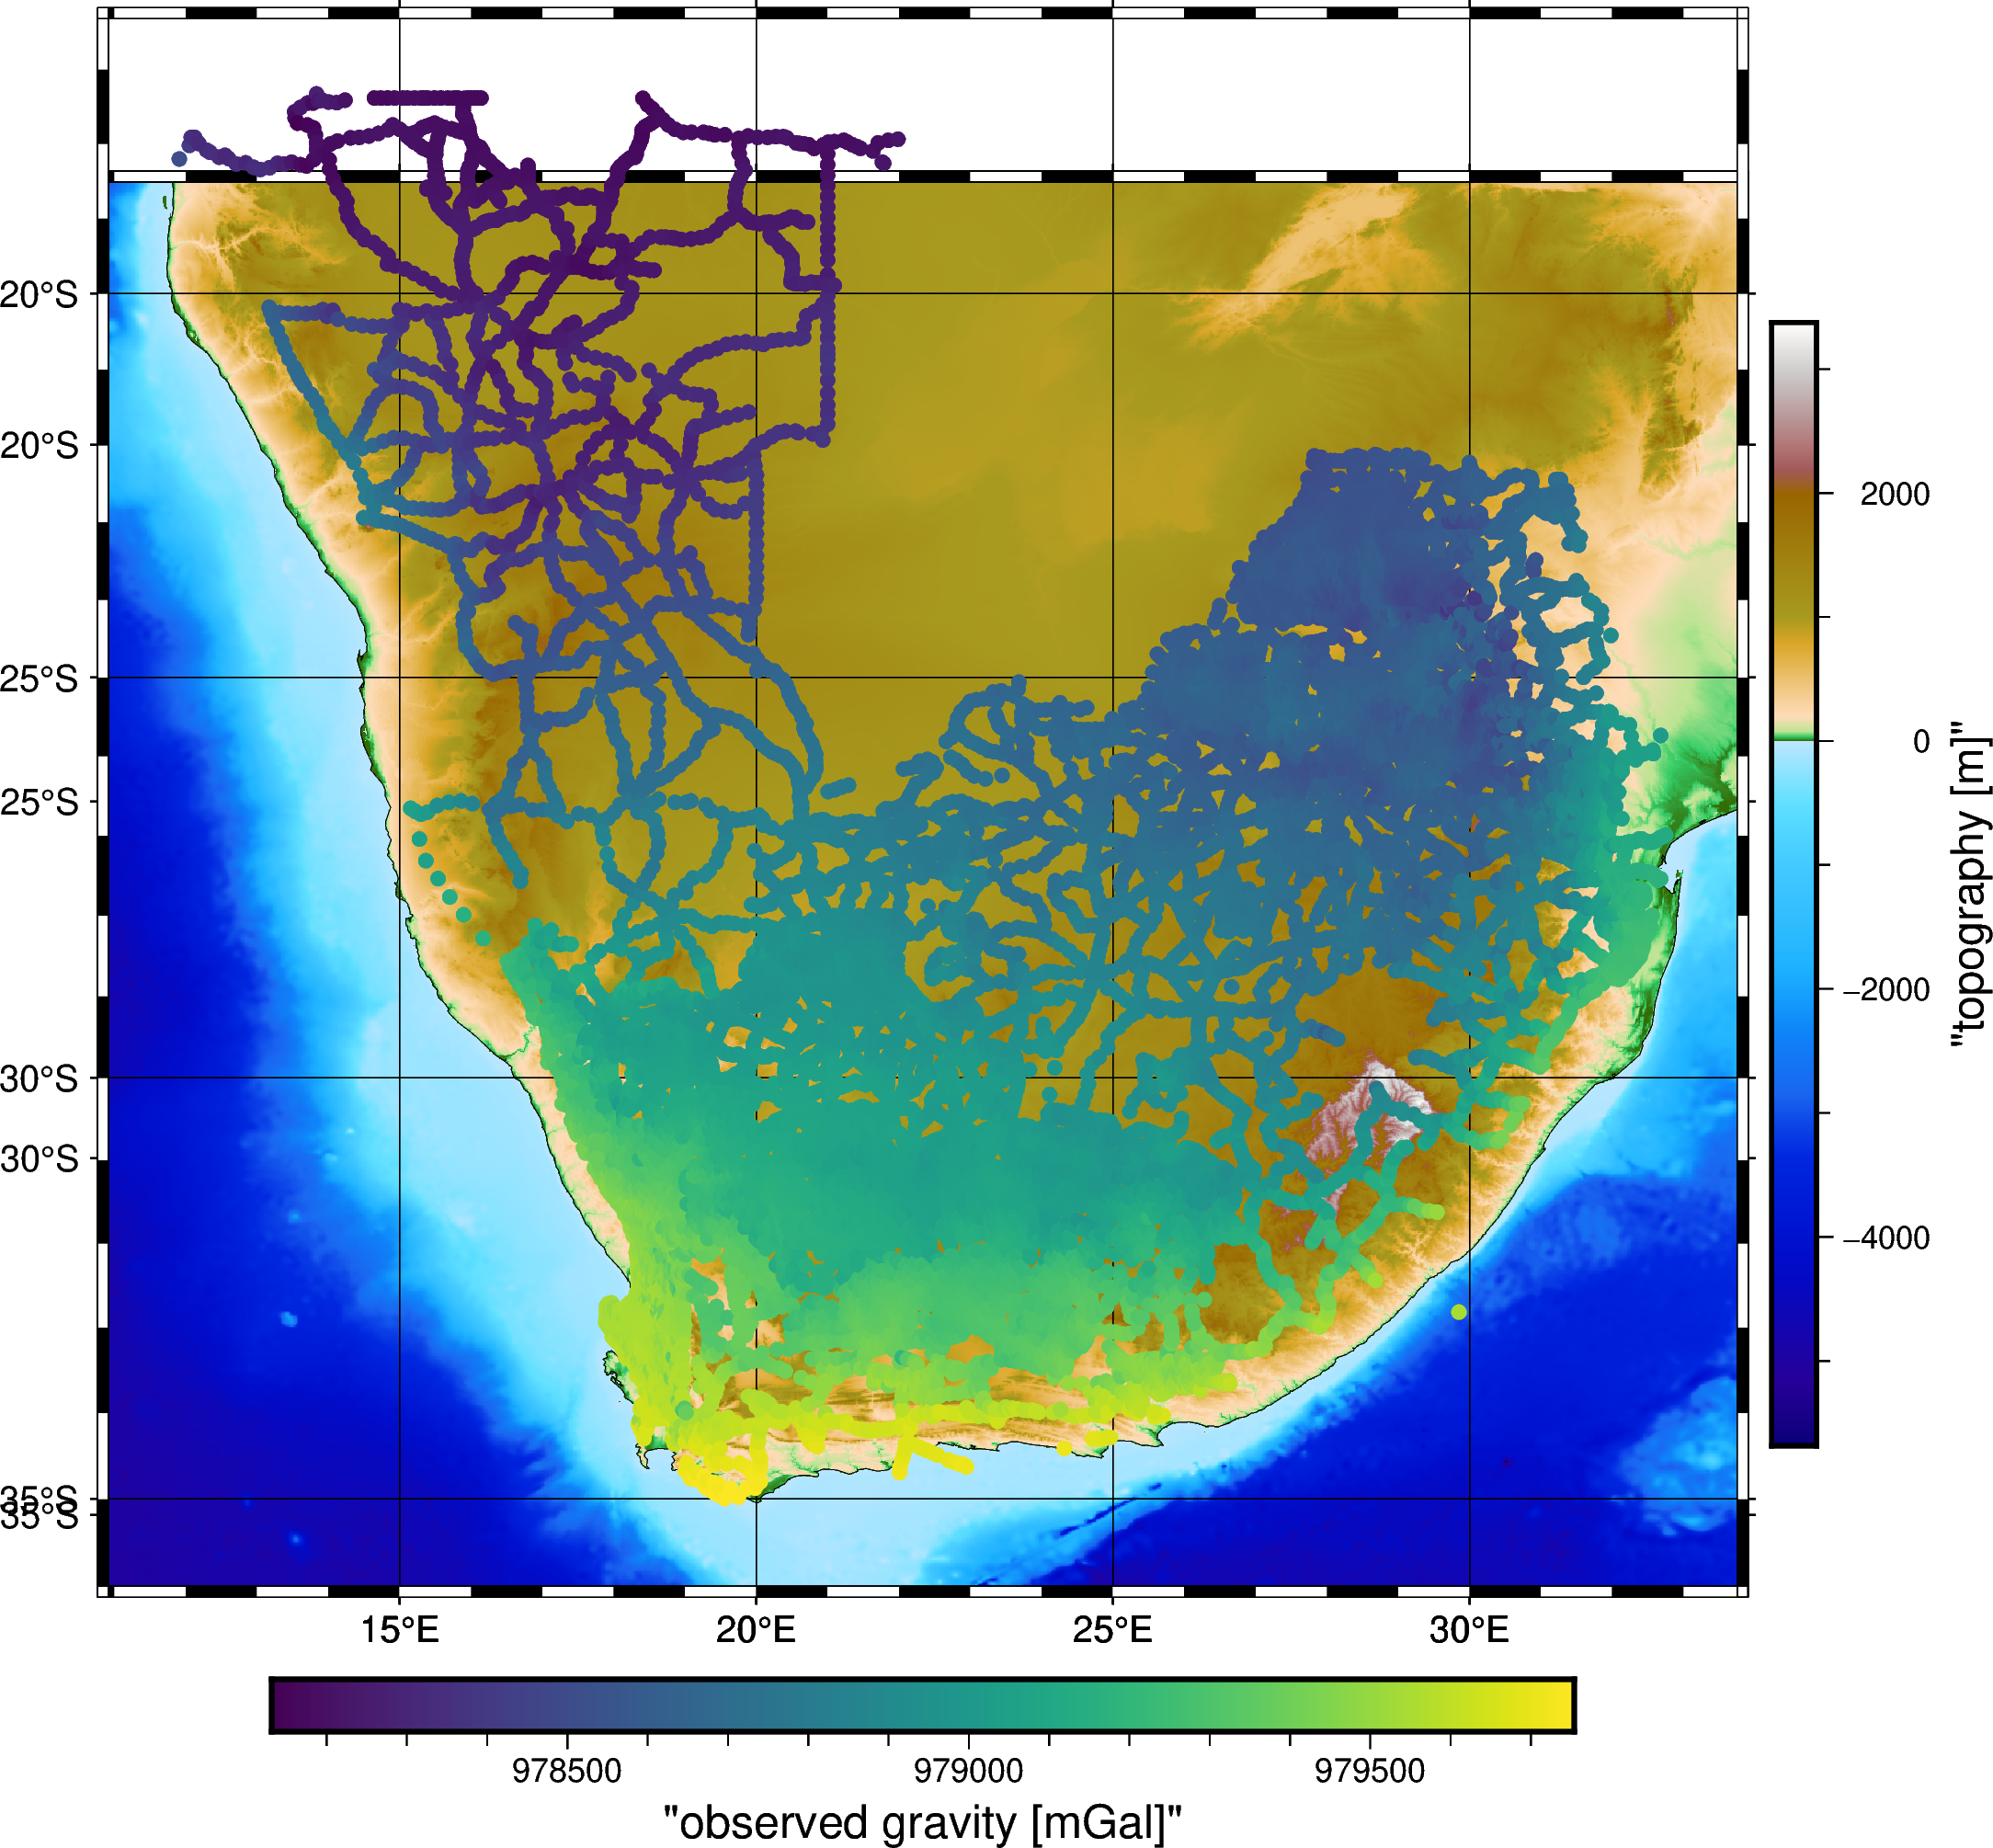

In [28]:
import pygmt

fig = pygmt.Figure()
fig.grdimage(topography, cmap="etopo1")
fig.colorbar(frame='af+l Topography [m]', position="JCR")
fig.basemap(frame=True)
fig.coast(shorelines="0.1p", area_thresh=1e4)

pygmt.makecpt(cmap="viridis", series=[data.gravity_mgal.min(), data.gravity_mgal.max()])
fig.plot(
    x=data.longitude,
    y=data.latitude,
    fill=data.gravity_mgal,
    cmap=True,
    style="c4p",
    projection="M15c",
    frame="afg",
)
fig.colorbar(frame='af+l Observed Gravity [mGal]')

fig.show()